In [1]:
# import os
import os
    
from sklearn.metrics import plot_roc_curve, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def import_data(path):
    '''
    returns dataframe for the csv found at pth

    input:
            path: a path to the csv
    output:
            data_frame: pandas dataframe
    '''
    # Import data
    data_frame = pd.read_csv(path)

    # Add response variable
    data_frame[
        'Churn'] = data_frame['Attrition_Flag'].apply(
            lambda val: 0 if val == "Existing Customer" else 1)

    return data_frame

In [3]:
df = import_data(r"./data/bank_data.csv")
df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


In [4]:
df.shape

(10127, 23)

In [5]:
df.isnull().sum()

Unnamed: 0                  0
CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Churn                       0
dtype: int64

In [6]:
df.describe()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
count,10127.000000,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,5063.000000,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.160660
std,2923.557422,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.367235
min,0.000000,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000000
25%,2531.500000,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000000
50%,5063.000000,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000000
75%,7594.500000,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000000
max,10126.000000,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,1.000000


In [7]:
def perform_eda(data_frame, path, save=True):
    '''
    perform eda on data_frame and save figures to images folder
    input:
            data_frame: pandas dataframe
            pth: directory to save the figures

    output:
            None
    '''
    # Generate histograms for Churn
    plt.figure(figsize=(20, 10))
    data_frame['Churn'].hist()
    if save is True:
        plt.savefig(path + "/Churn_Histogram.png")
    else:
        plt.show()

    # Generate histograms for Customer Age
    plt.figure(figsize=(20, 10))
    data_frame['Customer_Age'].hist()
    if save is True:
        plt.savefig(path + "/Customer_Age_Histogram.png")
    else:
        plt.show()

    # Generate histogram for Marital Status
    plt.figure(figsize=(20, 10))
    data_frame.Marital_Status.value_counts('normalize').plot(kind='bar')
    if save is True:
        plt.savefig(path + "/Marital_Status_Histogram.png")
    else:
        plt.show()

    # Generate heatmap of all features
    plt.figure(figsize=(20, 10))
    sns.heatmap(data_frame.corr(), annot=False, cmap='Dark2_r', linewidths=2)
    if save is True:
        plt.savefig(path + "/Heatmap.png")
    else:
        plt.show()

    # Generate histogram for Total Trans Count
    plt.figure(figsize=(20, 10))
    sns.distplot(data_frame['Total_Trans_Ct'])
    if save is True:
        plt.savefig(path + "/Total_Trans_Ct_Plot.png")
    else:
        plt.show()

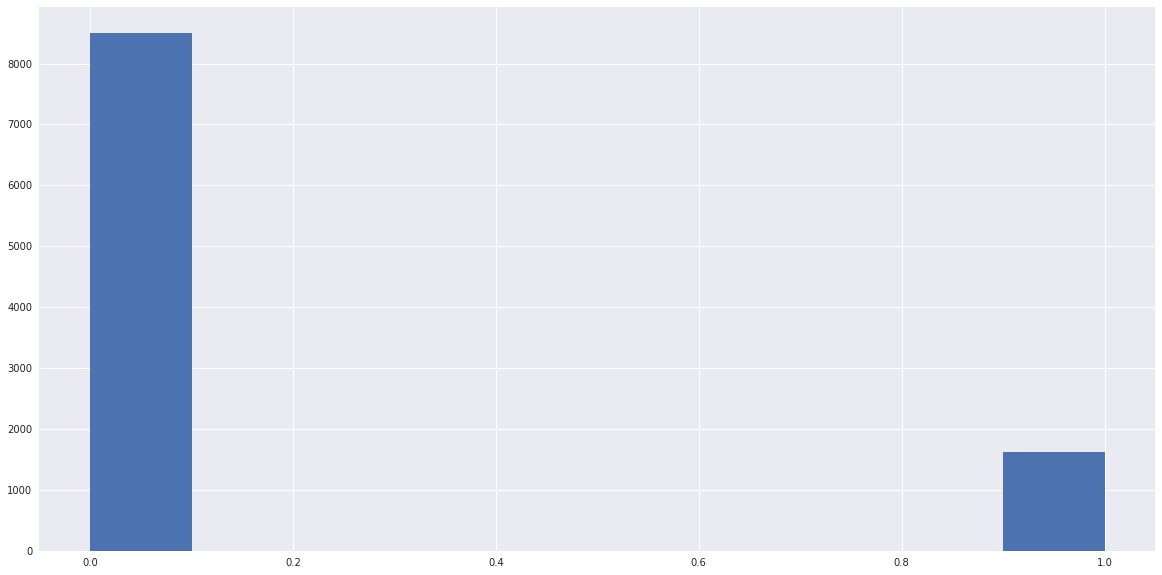

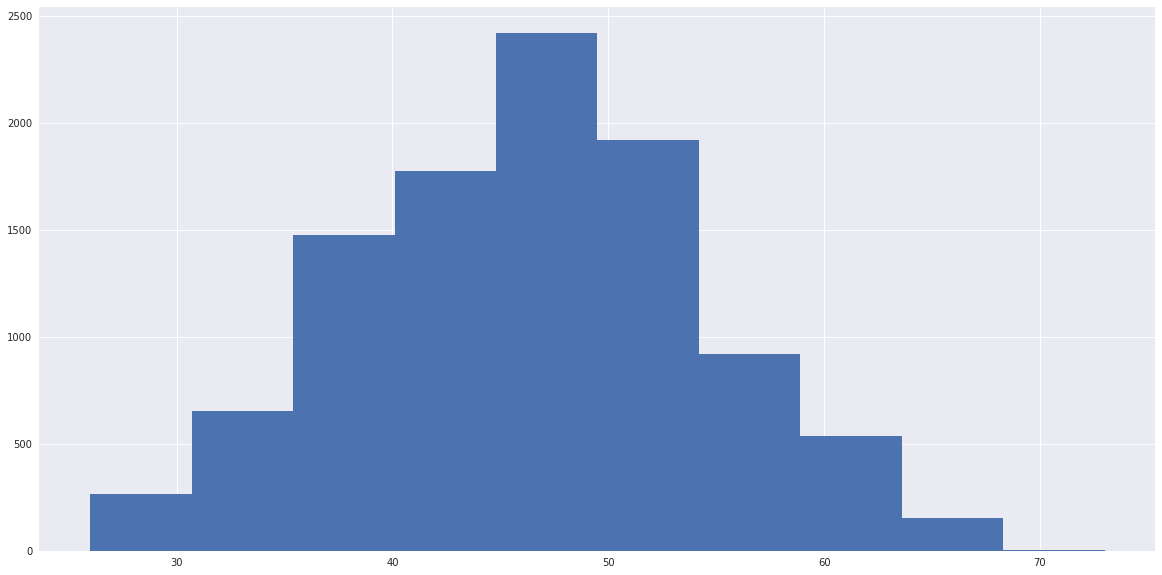

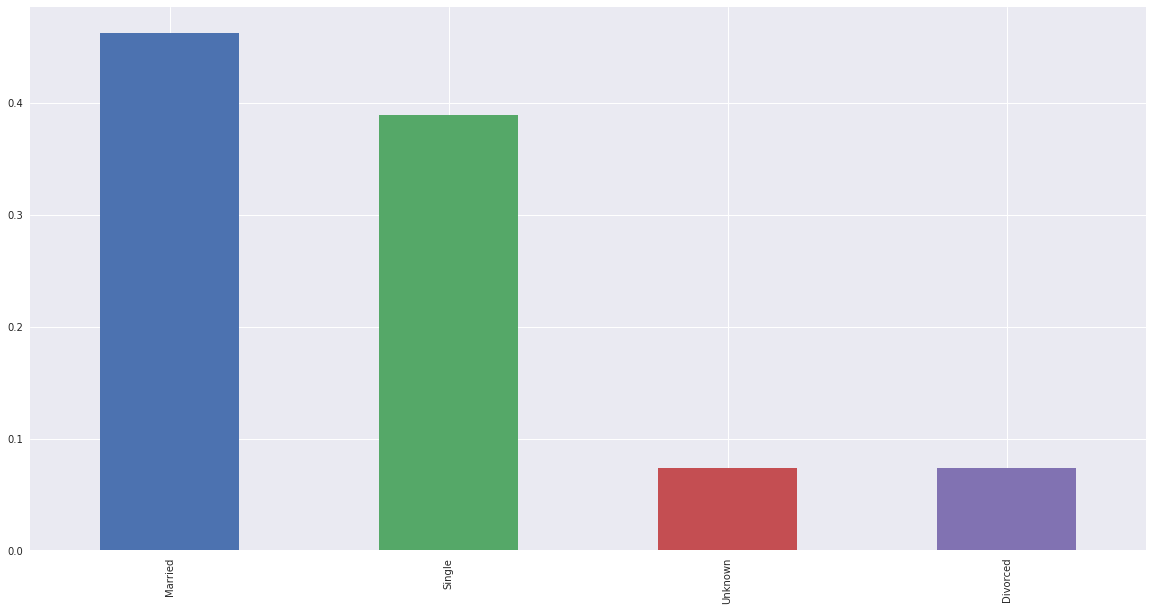

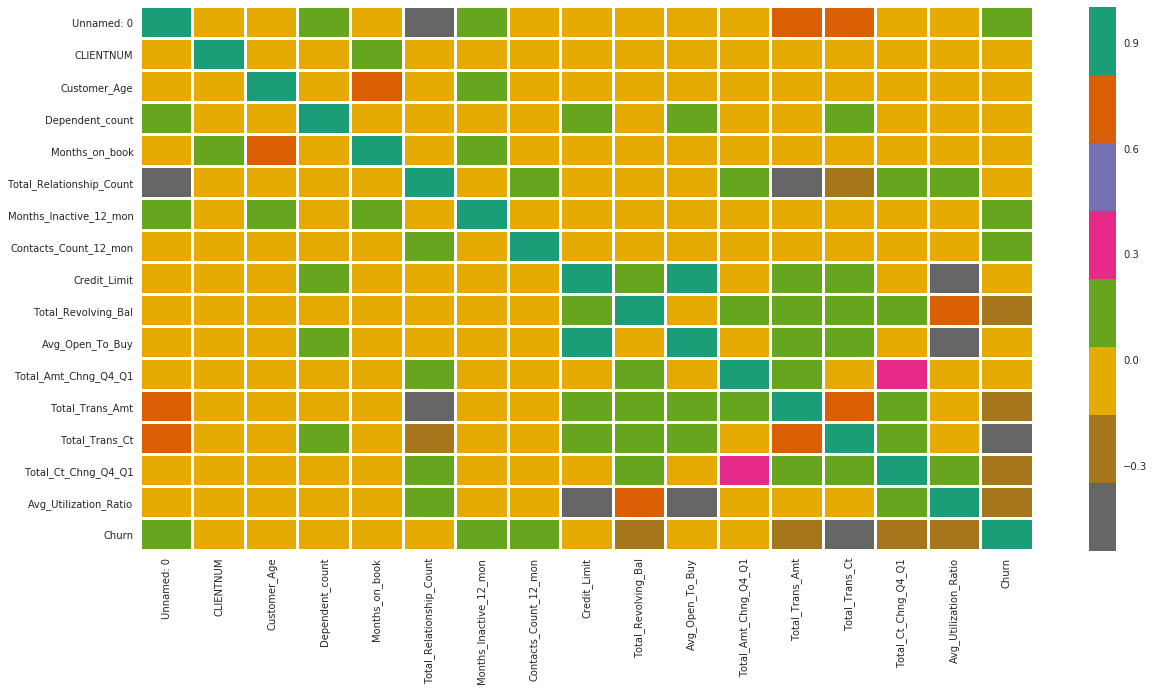

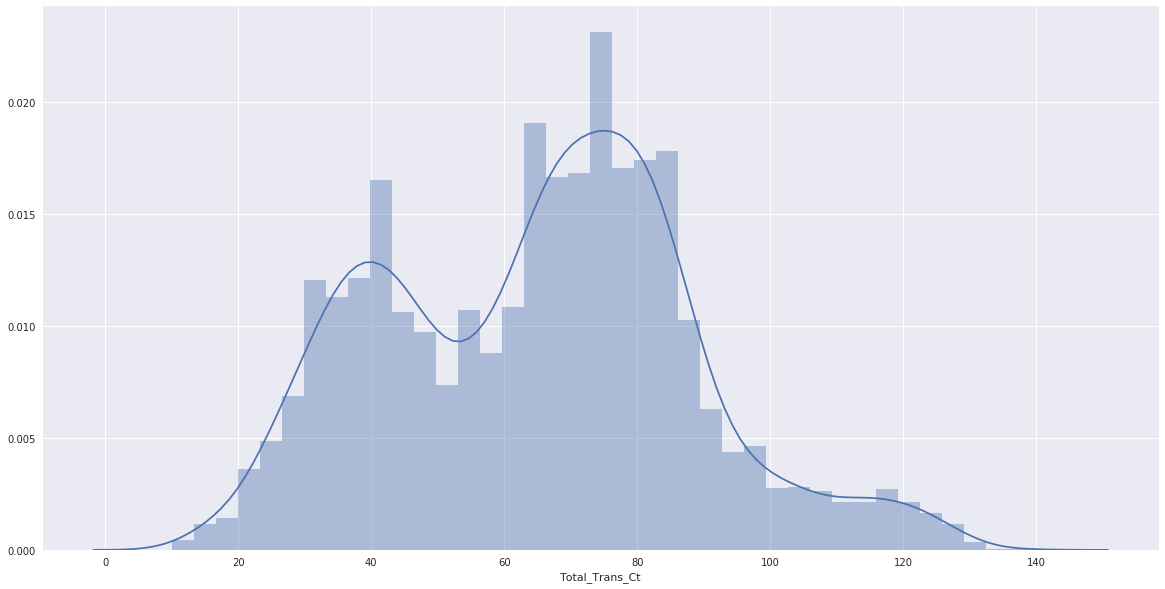

In [8]:
perform_eda(df, "./images/eda", save=False)

In [9]:
def encoder_helper(data_frame, category_list, response):
    '''
    helper function to turn each categorical column into a new column with
    propotion of churn for each category

    input:
            data_frame: pandas dataframe
            category_lst: list of columns that contain categorical features
            response: string of response name [optional argument that could be
                      used for naming variables or index y column]

    output:
            data_frame: pandas dataframe with new columns for
    '''
    for category in category_list:
        output_lst = []
        mean_groups = data_frame.groupby(category).mean()[response]
        for value in data_frame[category]:
            output_lst.append(mean_groups.loc[value])
        data_frame[category + '_' + response] = output_lst

    return data_frame

In [10]:
SELECTION = 'Churn'
categories = ['Gender', 'Education_Level', 'Marital_Status',
              'Income_Category', 'Card_Category']

df = encoder_helper(df, categories, SELECTION)

In [11]:
def perform_feature_engineering(data_frame, selected_features, response):
    '''
    Perform feature engineering and create the training and testing input tables

    input:
              data_frame: pandas dataframe
              selected_features: list of input model features
              response: target features

    output:
              x_train: X training data
              x_test: X testing data
              y_train: y training data
              y_test: y testing data
    '''
    # Create the target variable
    y_target = data_frame[response]

    # Create a container for the feature vector
    x_features = pd.DataFrame()
    x_features[selected_features] = data_frame[selected_features]

    # train test split
    x_train, x_test, y_train, y_test = train_test_split(
        x_features, y_target, test_size=0.3, random_state=42)

    return x_train, x_test, y_train, y_test

In [12]:
selected_features = [
    'Customer_Age', 'Dependent_count', 'Months_on_book',
    'Total_Relationship_Count', 'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
    'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
    'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn',
    'Income_Category_Churn', 'Card_Category_Churn']

In [13]:
response = 'Churn'

In [14]:
# train test split
X_train, X_test, y_train, y_test = perform_feature_engineering(
                                       df, selected_features, response)

In [15]:
X_train.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
415,49,2,38,3,2,0,8077.0,1965,6112.0,0.637,1329,26,0.444,0.243,0.146152,0.178295,0.151269,0.134807,0.160979
3749,61,0,51,4,2,2,8476.0,0,8476.0,0.675,3889,67,0.489,0.000,0.173572,0.152012,0.169414,0.168165,0.160979
9295,27,0,19,1,1,3,34516.0,1131,33385.0,0.715,14716,112,0.750,0.033,0.146152,0.152024,0.172230,0.157655,0.147748
8290,52,1,36,1,1,3,3040.0,2517,523.0,0.774,4608,61,1.033,0.828,0.173572,0.168532,0.151269,0.171862,0.160979
7672,44,3,36,2,3,3,2228.0,0,2228.0,0.686,2523,45,0.607,0.000,0.173572,0.152012,0.169414,0.171862,0.160979


In [16]:
X_test.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
3781,48,3,39,4,3,4,2991.0,1508,1483.0,0.703,3734,64,0.882,0.504,0.173572,0.159381,0.169414,0.171862,0.160979
2922,59,1,53,5,5,4,2192.0,1569,623.0,0.706,4010,79,0.717,0.716,0.146152,0.159381,0.169414,0.171862,0.160979
5070,37,2,36,4,3,3,1734.0,987,747.0,0.879,4727,67,0.914,0.569,0.173572,0.155691,0.161765,0.171862,0.160979
7246,47,3,36,4,2,3,4786.0,1516,3270.0,0.940,4973,74,0.850,0.317,0.146152,0.210643,0.161765,0.151397,0.160979
623,42,3,33,3,3,2,3714.0,2170,1544.0,0.524,1454,35,0.522,0.584,0.146152,0.168532,0.169414,0.157655,0.160979


In [17]:
y_train.head()

415     0
3749    0
9295    0
8290    0
7672    1
Name: Churn, dtype: int64

In [18]:
y_test.head()

3781    0
2922    0
5070    0
7246    0
623     0
Name: Churn, dtype: int64

In [19]:
def train_random_forest_model(x_train, y_train, search_param, path):
    '''
    train and store Random Forest Classifer to given path
    input:
              x_train: X training data
              y_train: y training data
              search_param: grid search parameters
              path: a path to the classifier
    output:
              None
    '''
    # Train the Random Forest Classifier
    rand_forest = RandomForestClassifier(random_state=42)
    cv_rand_forest = GridSearchCV(
        estimator=rand_forest,
        param_grid=search_param,
        cv=5)
    cv_rand_forest.fit(x_train, y_train)

    # Save the best Random Forest Classifier Model
    joblib.dump(
        cv_rand_forest.best_estimator_,
        path + "/random_forest_model.pkl")

In [20]:
# Define Grid Parameter
search_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

In [21]:
train_random_forest_model(X_train, y_train, search_param, "./models")

In [22]:
def train_logistic_regression_model(x_train, y_train, path):
    '''
    train, test and store Logistic Regression Classifer model results
    input:
              x_train: X training data
              y_train: y training data
              path: a path to the classifier
    output:
              None
    '''
    # Train the Logistic Regression Classifier
    log_reg = LogisticRegression()
    log_reg.fit(x_train, y_train)

    # Save the best Logistic Regression Model
    joblib.dump(log_reg, path + "/logistic_regression_model.pkl")

In [23]:
train_logistic_regression_model(X_train, y_train, "./models")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [24]:
def characterize_random_forest_model(x_train, x_test, y_train, y_test, path, save=True):
    '''
    characterize performance of Random Forest model
    input:
              x_train: X training data
              x_test: X testing data
              y_train: y training data
              y_test: y testing data
              path: a path to the classifier
              save: save image (True) or display image (False) 
    output:
              None
    '''
    # Load Random Forest Classifier
    rand_forest_model = joblib.load(path + "/random_forest_model.pkl")

    # Predict using Random Forest Classifier
    y_train_preds_rf = rand_forest_model.predict(x_train)
    y_test_preds_rf = rand_forest_model.predict(x_test)
    
    # Create image of model characterization report
    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace')
    plt.axis('off');
    if save is True:
        plt.savefig(path + "/Random_Forest_Metrics.png")
    else:
        plt.show()

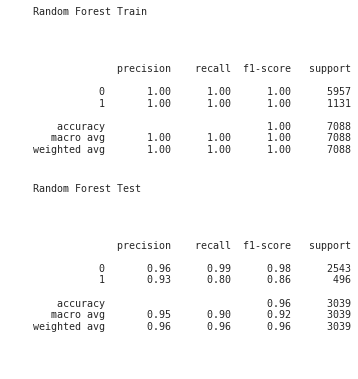

In [25]:
characterize_random_forest_model(X_train, X_test, y_train, y_test, "./models")

In [26]:
def characterize_logistic_regression_model(
        x_train, x_test, y_train, y_test, path, save=True):
    '''
    characterize performance of Logistic Regression model
    input:
              x_train: X training data
              x_test: X testing data
              y_train: y training data
              y_test: y testing data
              path: a path to the classifier
              save: save image (True) or display image (False) 
    output:
              None
    '''
    # Load the Logistic Regression model
    log_reg_model = joblib.load(path + "/logistic_regression_model.pkl")

    # Predict using Logistic Regression model
    y_train_preds_lr = log_reg_model.predict(x_train)
    y_test_preds_lr = log_reg_model.predict(x_test)
    
    # Create image of model characterization report
    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace')
    plt.axis('off');
    if save is True:
        plt.savefig(path + "/Logistic_Regression_Metrics.png")
    else:
        plt.show()

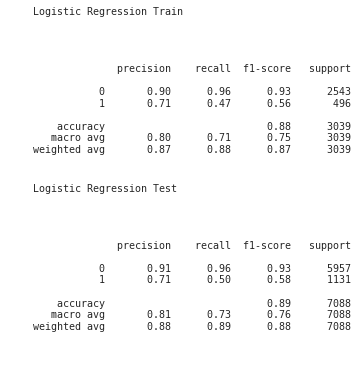

In [27]:
characterize_logistic_regression_model(X_train, X_test, y_train, y_test, "./models", save=False)

In [28]:
def plot_two_model_roc_curves(
        x_test,
        y_test,
        model_one_path,
        model_two_path,
        output_path,
        save=True):
    '''
    produces ROC curves for both models, plots them individually and together

    input:
            x_test: X testing data
            y_test: y testing data
            model_one_path: first model path
            model_two_path: second model path
            output_path: output_path
            save: True to save, False to show
    output:
             None
    '''
    # Load models
    model_one = joblib.load(model_one_path)
    model_two = joblib.load(model_two_path)

    # Plot model one individual ROC curve
    plt.figure(figsize=(15, 8))
    model_one_disp = plot_roc_curve(model_one, x_test, y_test)
    if save is True:
        plt.savefig(output_path + "/Model_One_ROC.png")
    else:
        plt.show()

    # Plot model two individual ROC curve
    plt.figure(figsize=(15, 8))
    model_two_disp = plot_roc_curve(model_two, x_test, y_test)
    if save is True:
        plt.savefig(output_path + "/Model_Two_ROC.png")
    else:
        plt.show()

    # Plot model two individual ROC curve
    plt.figure(figsize=(15, 8))
    model_one_disp = plot_roc_curve(model_one, x_test, y_test)
    model_two_disp = plot_roc_curve(
        model_two, x_test, y_test, ax=model_one_disp.ax_)
    model_two_disp.figure_.suptitle("ROC Curve Comparison")
    if save is True:
        plt.savefig(output_path + "/Combined_ROC.png")
    else:
        plt.show()  

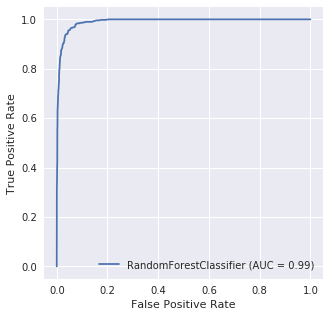

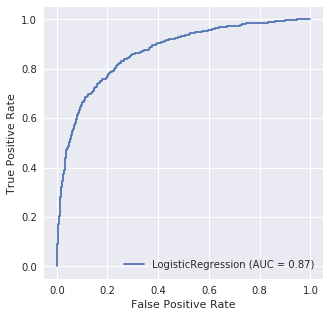

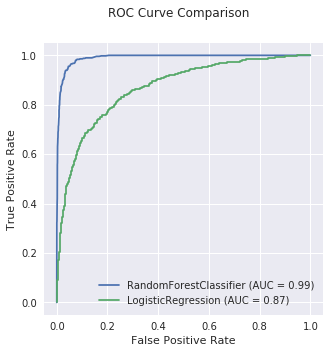

In [29]:
plot_two_model_roc_curves(X_test, y_test, "./models/random_forest_model.pkl", "./models/logistic_regression_model.pkl", "./images/results", save=False)

In [30]:
def shapely_plot(x_data, model_path, output_path, save=True):
    '''
    creates and stores the feature importances in path
    input:
            x_data: pandas dataframe of X values
            model_path: path to model object
            output_pth: path to store the figure
            save: True to save, False to show
    output:
             None
    '''
    # Load model
    model = joblib.load(model_path)
    
    # Calculate feature explainer
    explainer = shap.TreeExplainer(model)
    
    # Generate Shapely values
    shapely_values = explainer.shap_values(x_data)
    
    # Create plot
    plt.figure(figsize=(20, 5))
    plt.title("Shapely Summary Plot")
    shap.summary_plot(shapely_values, x_data, plot_type="bar")
    if save is True:
        plt.savefig(output_path + "Shapely_Summary_Plot.png")
    else:
        plt.show()

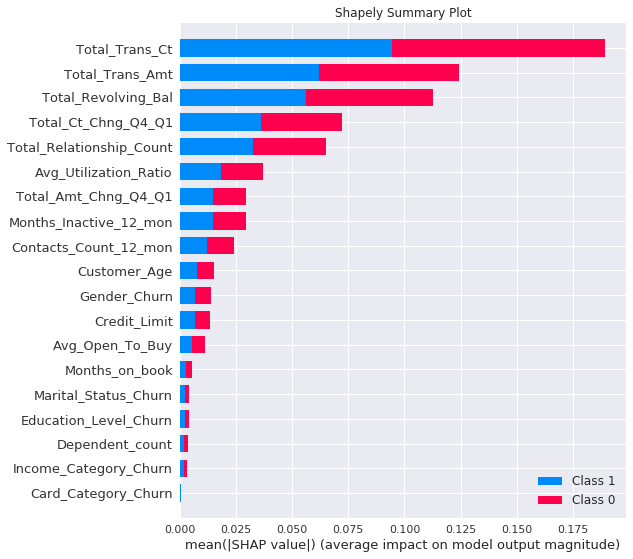

In [31]:
shapely_plot(X_test, "./models/random_forest_model.pkl", "./images/results/rf_", save=False)

In [32]:
def feature_importance_plot(x_data, model_path, output_path, save=True):
    '''
    creates and stores the feature importances in path
    input:
            x_data: pandas dataframe of X values
            model_path: path to model object
            output_pth: path to store the figure
            save: True to save, False to show
    output:
             None
    '''
    # Load model
    model = joblib.load(model_path)
    
    # Calculate feature importances
    importances = model.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [x_data.columns[i] for i in indices]

    # Create plot
    plt.figure(figsize=(20,5))
    plt.title("Feature Importance")
    plt.ylabel('Importance')
    plt.bar(range(x_data.shape[1]), importances[indices])
    plt.xticks(range(x_data.shape[1]), names, rotation=90)
    if save is True:
        plt.savefig(output_path + "Feature_Importance_Plot.png")
    else:
        plt.show()

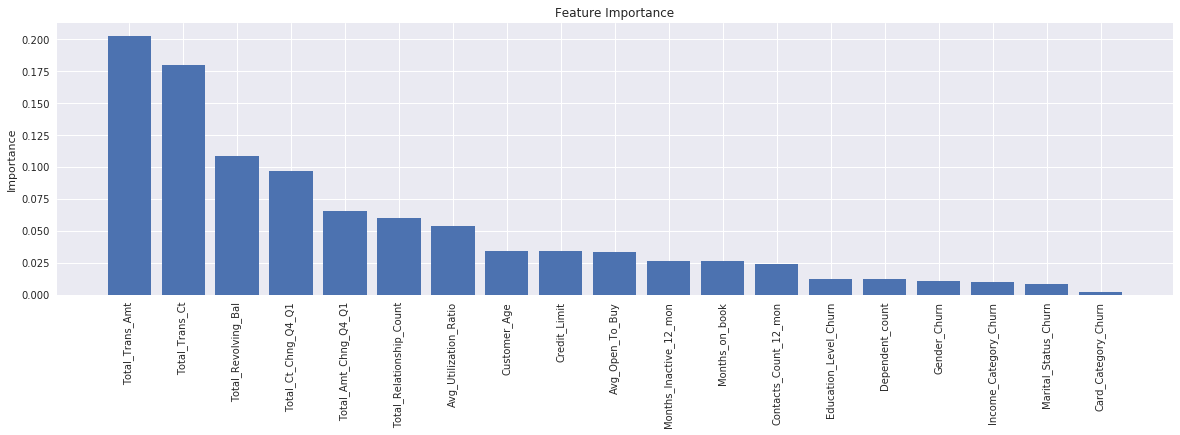

In [33]:
feature_importance_plot(X_test, "./models/random_forest_model.pkl", "./images/results/rf_", save=False)